In [1]:
#dataloader
import pickle
import cv2
import random

class dataloader:
    def __init__(self,root,pkl_name):
        self.root = root
        self.pkl_name = pkl_name
        self.load_data()
    def load_data(self):
        pkl=pickle.load(open(self.root+self.pkl_name,'rb'))
        self.all_labels=pkl['all_labels']
        self.all_imagenames=pkl['all_imagenames']
        self.train_labels=pkl['train_labels']
        self.train_imagenames=pkl['train_imagenames']
        self.test_labels=pkl['test_labels']
        self.test_imagenames=pkl['test_imagenames']
        self.mapping=pkl['mapping']
    
    def get_single_pair(self,index):
        img=cv2.imread(self.root+self.all_imagenames[index])
        return img,self.all_labels[index]
    def get_single_img(self,index):
        img=cv2.imread(self.root+self.all_imagenames[index])
        return img
    def get_single_label(self,index):
        return self.all_labels[index]
    def get_single_test_pair(self,index):
        img=cv2.imread(self.root+self.test_imagenames[index])
        return img,self.test_labels[index]
    
    def get_train_set(self):
        tmp_path=[self.root+i for i in self.train_imagenames]
        tmp_label=self.train_labels.copy()
        tmp=list(zip(tmp_path,tmp_label))
        random.shuffle(tmp)
        tmp_path,tmp_label=zip(*tmp)
        return tmp_path,tmp_label
    def get_test_set(self):
        tmp_path=[self.root+i for i in self.test_imagenames]
        tmp_label=self.test_labels.copy()
        tmp=list(zip(tmp_path,tmp_label))
        random.shuffle(tmp)
        tmp_path,tmp_label=zip(*tmp)
        return tmp_path,tmp_label
    
data=dataloader('./data/','traintest.pkl')
print(len(data.all_labels))
print(len(data.train_labels))
print(len(data.test_labels))

1491
1331
160


Text(0.5, 1.0, 'Harris Points')

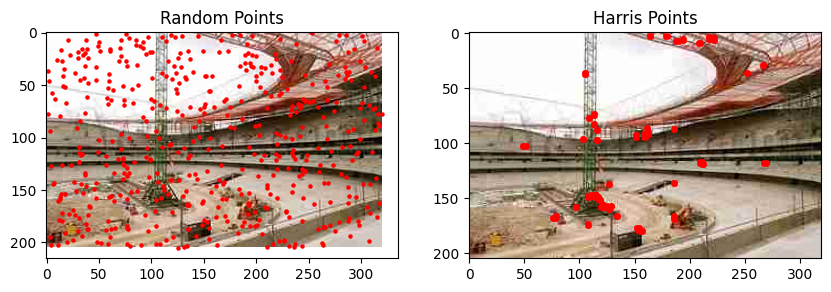

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_random_points(img, alpha):
    height, width = img.shape[:2]
    points = np.zeros((alpha, 2), dtype=np.float32)
    
    points[:, 0] = np.random.rand(alpha) * width  # x 坐标
    points[:, 1] = np.random.rand(alpha) * height # y 坐标
    
    # 归一化坐标
    points[:, 0] /= width
    points[:, 1] /= height
    
    return points

def get_harris_points(img, alpha, k=0.04):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    gray = np.float32(gray)
    
    # Harris 角点检测
    harris_response = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=k)
    
    # 结果进行膨胀，以便更清晰地标记角点
    harris_response = cv2.dilate(harris_response, None)
    
    # 获取角点的坐标
    keypoints = np.argwhere(harris_response > 0.01 * harris_response.max())
    
    if len(keypoints) > alpha:
        # 如果角点数量超过 alpha，则根据响应值进行排序并选择前 alpha 个
        keypoints = sorted(keypoints, key=lambda x: harris_response[x[0], x[1]], reverse=True)[:alpha]
    
    keypoints = np.array(keypoints, dtype=np.float32)
    
    # 归一化坐标
    keypoints[:, 1] /= img.shape[1]  # x 坐标归一化
    keypoints[:, 0] /= img.shape[0]  # y 坐标归一化
    
    return keypoints

# 示例使用
img,L=data.get_single_test_pair(100)
alpha = 500
random_points = get_random_points(img, alpha)
harris_points = get_harris_points(img, alpha)

# 绘制随机点
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(random_points[:, 0] * img.shape[1], random_points[:, 1] * img.shape[0], c='r', s=5)
plt.title('Random Points')

# 绘制 Harris 角点
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(harris_points[:, 1] * img.shape[1], harris_points[:, 0] * img.shape[0], c='r', s=5)
plt.title('Harris Points')



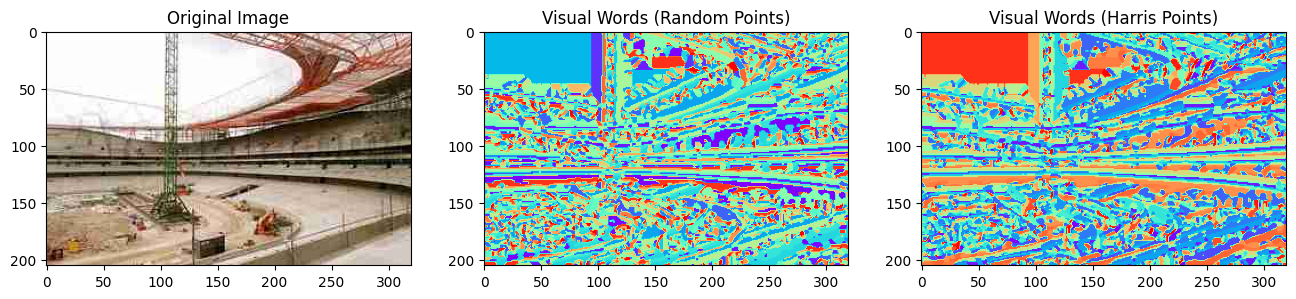

In [3]:
from sklearn.cluster import KMeans


def extract_features(img, points):
    sift = cv2.SIFT_create()
    h, w = img.shape[:2]
    keypoints = [cv2.KeyPoint(x * w, y * h, 1) for x, y in points]
    keypoints, descriptors = sift.compute(img, keypoints)
    return descriptors

def get_dictionary(imgPaths, alpha, K, method='random',cmp=False):
    descriptors_list = []

    for imgPath in imgPaths:
        img = cv2.imread(imgPath)
        if cmp:
            img = cv2.resize(img,(16,16))
        if img is None:
            continue
        
        if method == 'random':
            points = get_random_points(img, alpha)
        elif method == 'harris':
            points = get_harris_points(img, alpha)
        else:
            raise ValueError("Method should be 'random' or 'harris'")
        
        descriptors = extract_features(img, points)
        if descriptors is not None:
            descriptors_list.append(descriptors)

    # 将所有描述符合并为一个大数组
    all_descriptors = np.vstack(descriptors_list)
    
    # K-Means 聚类
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(all_descriptors)
    
    dictionary = kmeans.cluster_centers_
    
    return dictionary

from scipy.spatial.distance import cdist
def get_sift_descriptors(img):
    sift = cv2.SIFT_create()
    keypoints = [cv2.KeyPoint(x=x, y=y, size=1) for y in range(img.shape[0]) for x in range(img.shape[1])]
    _, descriptors = sift.compute(img, keypoints)
    return keypoints, descriptors

def get_visual_words(img, dictionary,cmp=False):
    if cmp:
        img = cv2.resize(img,(16,16))
    h, w = img.shape[:2]
    keypoints, descriptors = get_sift_descriptors(img)
    # print(descriptors.shape)
    # # 如果图像中没有检测到任何特征点，则返回全零的wordMap
    # if descriptors is None:
    #     return np.zeros((h, w), dtype=int)

    # 计算描述符与字典中每个单词的距离
    distances = cdist(descriptors, dictionary, metric='euclidean')
    
    # 找到每个描述符最接近的字典单词索引
    word_indices = np.argmin(distances, axis=1)
    
    # 创建一个空的wordMap
    wordMap = np.zeros((h, w), dtype=int)
    
    # 将每个关键点的位置映射到wordMap中
    for kp, word_idx in zip(keypoints, word_indices):
        x, y = int(kp.pt[0]), int(kp.pt[1])
        wordMap[y, x] = word_idx
    
    return wordMap

train_imgPaths, train_labels = data.get_train_set()
test_imgPaths, test_labels = data.get_test_set()

dictionary_random = get_dictionary(train_imgPaths, alpha=500, K=32, method='random')
dictionary_harris = get_dictionary(train_imgPaths, alpha=500, K=32, method='harris')
wordMap1 = get_visual_words(img, dictionary_random)
wordMap2 = get_visual_words(img, dictionary_harris)


plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(wordMap1, cmap='rainbow')
plt.title('Visual Words (Random Points)')
plt.subplot(1, 3, 3)
plt.imshow(wordMap2, cmap='rainbow')
plt.title('Visual Words (Harris Points)')
plt.show()




In [4]:
def get_image_features(wordMap, dictionarySize):
    h = np.zeros(dictionarySize, dtype=int)
    
    # 计算每个单词的出现次数
    for i in range(dictionarySize):
        h[i] = np.sum(wordMap == i)
    
    return h/h.sum()

def nearest_neighbor_classify(train_features, train_labels, test_features):
    distances = cdist([test_features], train_features, metric='euclidean')
    nearest_idx = np.argmin(distances)
    return train_labels[nearest_idx]

def classify_images(train_features, train_labels, test_features):
    predictions = []
    for test_feature in test_features:
        prediction = nearest_neighbor_classify(train_features, train_labels, test_feature)
        predictions.append(prediction)
    return predictions


feature1=get_image_features(wordMap1, dictionary_random.shape[0])
feature2=get_image_features(wordMap2, dictionary_harris.shape[0])



train_features = []
for imgPath in train_imgPaths:
    img = cv2.imread(imgPath)
    wordMap = get_visual_words(img, dictionary_random)
    feature = get_image_features(wordMap, dictionary_random.shape[0])
    train_features.append(feature)

test_features = []
for imgPath in test_imgPaths:
    img = cv2.imread(imgPath)
    wordMap = get_visual_words(img, dictionary_random)
    feature = get_image_features(wordMap, dictionary_random.shape[0])
    test_features.append(feature)

predictions = classify_images(train_features, train_labels, test_features)


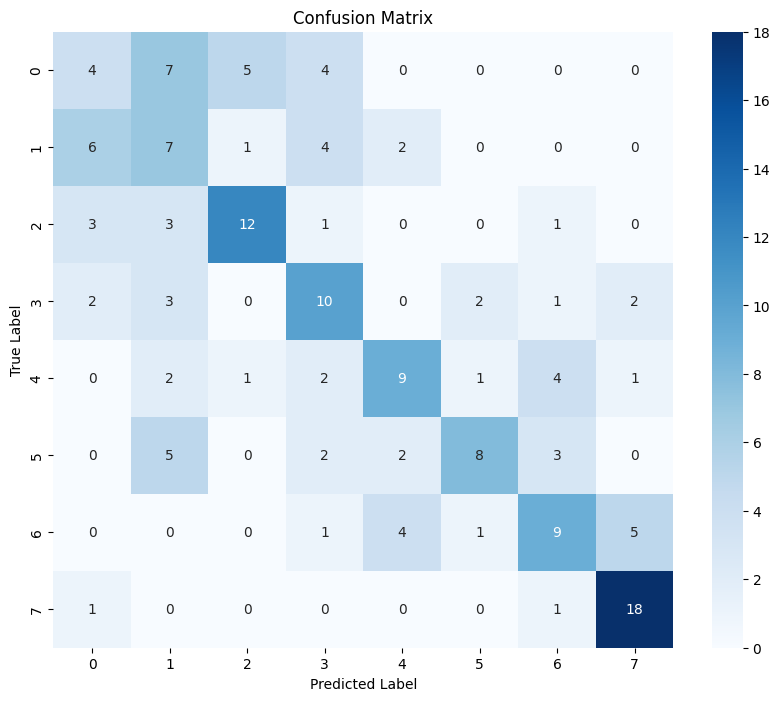

Accuracy: 0.48125
Precision: 0.48994690093761295
Recall: 0.48125000000000007
F1 Score: 0.47758228453186824


In [5]:
#评估结果 混淆矩阵 accuracy precision recall f1

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
true_labels = test_labels[:]
confusion = confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

#可视化混淆矩阵
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

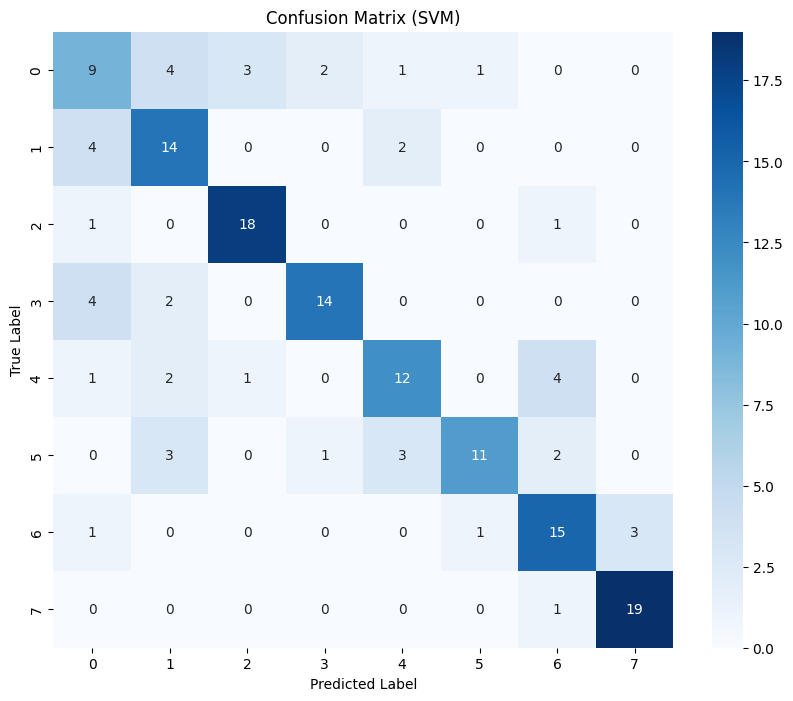

Accuracy (SVM): 0.7
Precision (SVM): 0.7100427524308598
Recall (SVM): 0.7
F1 Score (SVM): 0.698350471690435


In [6]:
#SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


#RBF核
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
clf.fit(train_features, train_labels[:len(train_features)])
predictions_svc = clf.predict(test_features)
confusion_svc = confusion_matrix(true_labels, predictions_svc)
accuracy_svc = accuracy_score(true_labels, predictions_svc)
precision_svc = precision_score(true_labels, predictions_svc, average='macro')
recall_svc = recall_score(true_labels, predictions_svc, average='macro')
f1_svc = f1_score(true_labels, predictions_svc, average='macro')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_svc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM)')
plt.show()

print('Accuracy (SVM):', accuracy_svc)
print('Precision (SVM):', precision_svc)
print('Recall (SVM):', recall_svc)
print('F1 Score (SVM):', f1_svc)

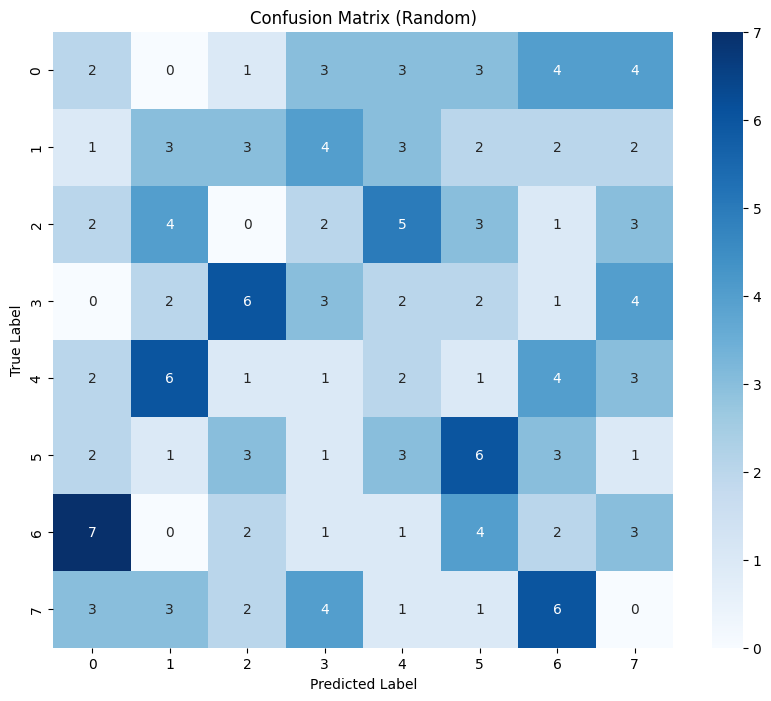

Accuracy (Random): 0.1125
Precision (Random): 0.11009205325566881
Recall (Random): 0.1125
F1 Score (Random): 0.11112424397308118


In [22]:
predictions_ran=np.zeros(len(true_labels))
#随机分类
for i in range(len(true_labels)):
    predictions_ran[i]=random.randint(1,8)
confusion_ran = confusion_matrix(true_labels, predictions_ran)
accuracy_ran = accuracy_score(true_labels, predictions_ran)
precision_ran = precision_score(true_labels, predictions_ran, average='macro')
recall_ran = recall_score(true_labels, predictions_ran, average='macro')
f1_ran = f1_score(true_labels, predictions_ran, average='macro')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_ran, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random)')
plt.show()

print('Accuracy (Random):', accuracy_ran)
print('Precision (Random):', precision_ran)
print('Recall (Random):', recall_ran)
print('F1 Score (Random):', f1_ran)

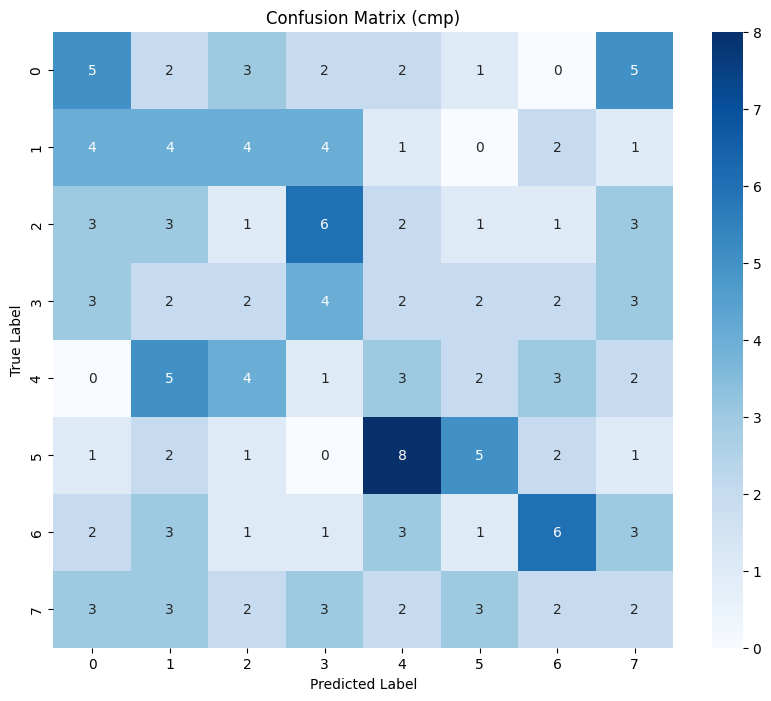

Accuracy (cmp): 0.1875
Precision (cmp): 0.19348688750862664
Recall (cmp): 0.1875
F1 Score (cmp): 0.1893140992661099


In [8]:
#cmp

dictionary_cmp=get_dictionary(train_imgPaths, alpha=500, K=32, method='harris',cmp=True)
train_features_cmp = []
for imgPath in train_imgPaths:
    img = cv2.imread(imgPath)
    wordMap = get_visual_words(img, dictionary_cmp,cmp=True)
    feature = get_image_features(wordMap, dictionary_cmp.shape[0])
    train_features_cmp.append(feature)

test_features_cmp = []
for imgPath in test_imgPaths:
    img = cv2.imread(imgPath)
    wordMap = get_visual_words(img, dictionary_cmp,cmp=True)
    feature = get_image_features(wordMap, dictionary_cmp.shape[0])
    test_features_cmp.append(feature)

predictions_cmp = classify_images(train_features_cmp, train_labels, test_features_cmp)

true_labels_cmp = test_labels
confusion_cmp = confusion_matrix(true_labels_cmp, predictions_cmp)
accuracy_cmp = accuracy_score(true_labels_cmp, predictions_cmp)
precision_cmp = precision_score(true_labels_cmp, predictions_cmp, average='macro')
recall_cmp = recall_score(true_labels_cmp, predictions_cmp, average='macro')
f1_cmp = f1_score(true_labels_cmp, predictions_cmp, average='macro')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_cmp, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (cmp)')
plt.show()

print('Accuracy (cmp):', accuracy_cmp)
print('Precision (cmp):', precision_cmp)
print('Recall (cmp):', recall_cmp)
print('F1 Score (cmp):', f1_cmp)



Text(0.5, 1.0, 'Feature Histogram(Harries)')

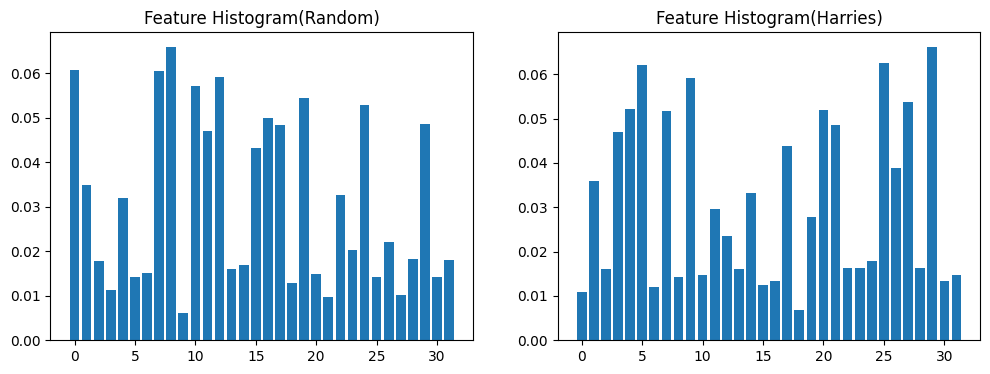

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

#feature1直方图
plt.bar(range(len(feature1)), feature1)
plt.title('Feature Histogram(Random)')

plt.subplot(1, 2, 2)
#feature2直方图
plt.bar(range(len(feature2)), feature2)
plt.title('Feature Histogram(Harries)')



In [10]:
train_features_H = []
for imgPath in train_imgPaths:
    img = cv2.imread(imgPath)
    wordMap = get_visual_words(img, dictionary_harris)
    feature = get_image_features(wordMap, dictionary_random.shape[0])
    train_features_H.append(feature)

test_features_H = []
for imgPath in test_imgPaths:
    img = cv2.imread(imgPath)
    wordMap = get_visual_words(img, dictionary_harris)
    feature = get_image_features(wordMap, dictionary_random.shape[0])
    test_features_H.append(feature)

predictions = classify_images(train_features_H, train_labels, test_features_H)

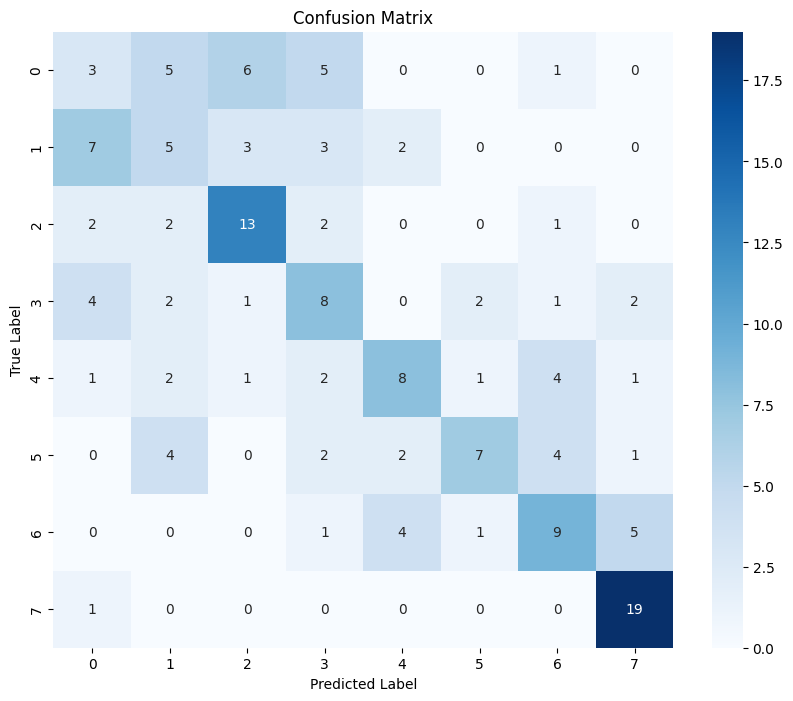

Accuracy: 0.45
Precision: 0.446386810653115
Recall: 0.45
F1 Score: 0.43857760816799096


In [11]:
true_labels = test_labels[:]
confusion = confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

#可视化混淆矩阵
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

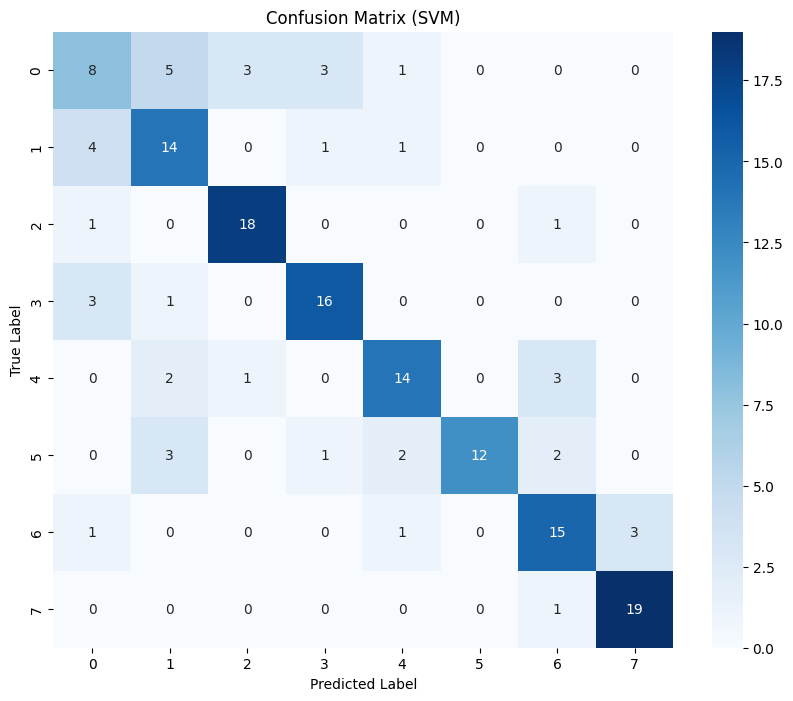

Accuracy (SVM): 0.725
Precision (SVM): 0.7366214332623002
Recall (SVM): 0.7250000000000001
F1 Score (SVM): 0.7224102067089871


In [12]:
#RBF核
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
clf.fit(train_features_H, train_labels[:len(train_features_H)])
predictions_svc = clf.predict(test_features_H)

confusion_svc = confusion_matrix(true_labels, predictions_svc)
accuracy_svc = accuracy_score(true_labels, predictions_svc)
precision_svc = precision_score(true_labels, predictions_svc, average='macro')
recall_svc = recall_score(true_labels, predictions_svc, average='macro')
f1_svc = f1_score(true_labels, predictions_svc, average='macro')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_svc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM)')
plt.show()

print('Accuracy (SVM):', accuracy_svc)
print('Precision (SVM):', precision_svc)
print('Recall (SVM):', recall_svc)
print('F1 Score (SVM):', f1_svc)

In [13]:
print(train_features[:10])
print(train_features_H[:10])

[array([6.17838542e-02, 3.27864583e-02, 2.29817708e-02, 2.93750000e-02,
       3.81640625e-02, 3.80859375e-02, 2.25390625e-02, 3.32812500e-02,
       1.30208333e-05, 2.11197917e-02, 3.16927083e-02, 3.26171875e-02,
       4.10156250e-02, 1.89973958e-02, 2.22786458e-02, 4.17317708e-02,
       5.21093750e-02, 2.31119792e-02, 2.18619792e-02, 3.78255208e-02,
       2.44531250e-02, 1.62760417e-02, 5.65625000e-02, 3.27343750e-02,
       4.46614583e-02, 2.22265625e-02, 4.14322917e-02, 2.09765625e-02,
       2.56510417e-02, 3.64062500e-02, 2.33463542e-02, 3.19010417e-02]), array([0.03111796, 0.02297535, 0.01484742, 0.03840962, 0.03173415,
       0.04464495, 0.03370012, 0.02849178, 0.00391725, 0.01748826,
       0.03713322, 0.05539906, 0.03582746, 0.02827171, 0.04433685,
       0.02717136, 0.03794014, 0.01904343, 0.01075411, 0.04039026,
       0.03400822, 0.02224178, 0.05470951, 0.02492664, 0.04247359,
       0.03995012, 0.04066901, 0.02093603, 0.02879988, 0.01682805,
       0.03185153, 0.039011

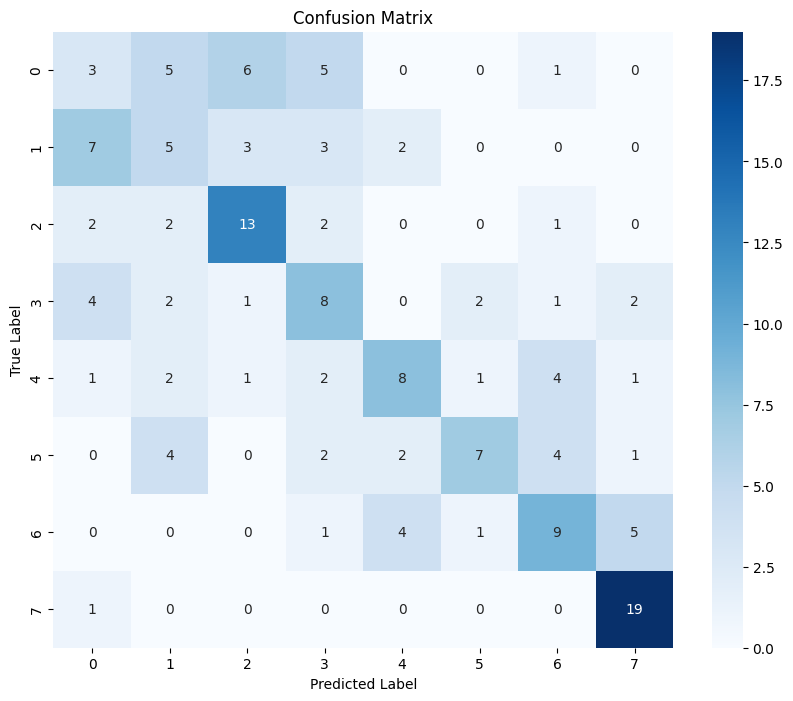

Accuracy: 0.45
Precision: 0.446386810653115
Recall: 0.45
F1 Score: 0.43857760816799096


In [24]:
predictions0=classify_images(train_features, train_labels, test_features)

clf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
clf.fit(train_features, train_labels[:len(train_features)])
predictions_svc1 = clf.predict(test_features)

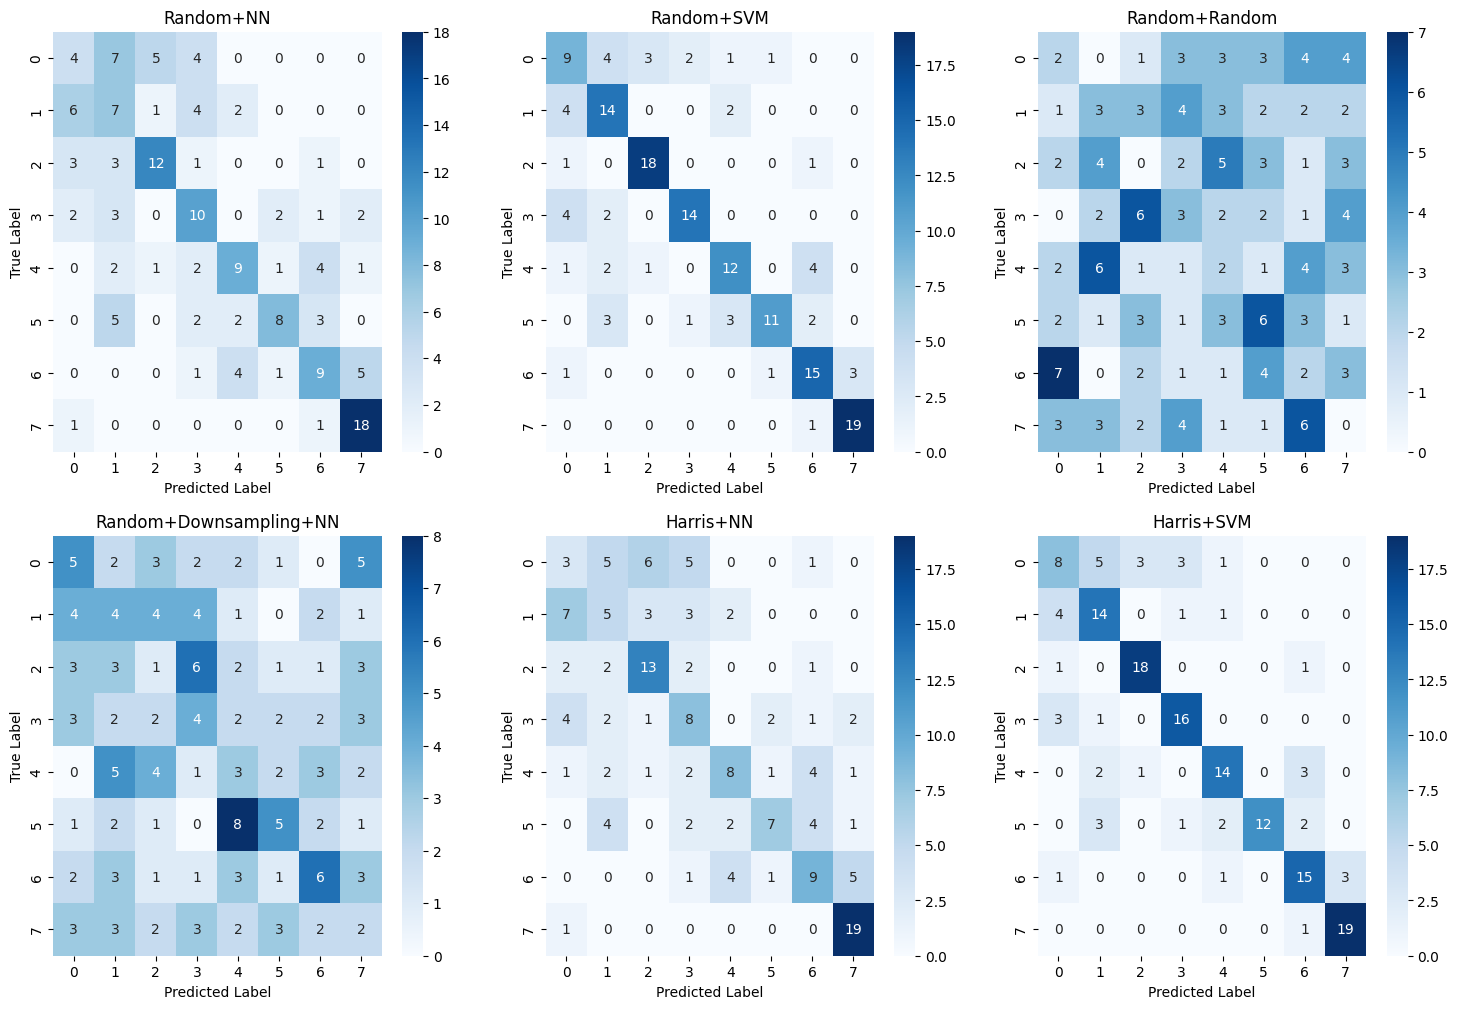

In [28]:
preds=[predictions0,predictions_svc1,predictions_ran,predictions_cmp,predictions,predictions_svc]
names=['Random+NN','Random+SVM','Random+Random','Random+Downsampling+NN','Harris+NN','Harris+SVM']

plt.figure(figsize=(20, 12))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sns.heatmap(confusion_matrix(true_labels, preds[i]), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(names[i])
plt.show()